In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch

In [2]:
from pathlib import Path
import sys

try:
    ROOT = Path().resolve().parents[1]
    assert (ROOT / "common").exists()
except AssertionError:
    ROOT = next(p for p in Path().resolve().parents if (p / "common").exists())

if str(ROOT) not in sys.path:
    sys.path.append(str(ROOT))

In [3]:
print(ROOT)

C:\Users\asus\Desktop\Аспирантура\Диссертация\Chapter I\Program Complex for chapter I


In [4]:
from common import sensors as sn 
from common import subspace_methods as sm
from common import hungarian_algorithm as ha
from common import diff_sensor_structures as dss

# Testing of SNR function

In [5]:
DIST_RATIO = 0.5

Num_sensors1 = 5
Num_emitters1 = 1
sample_size1 = 80
theta1_rad = np.array([0.7]) # Угловые координаты источников (DoA) в радианах
P = 1 * np.eye(Num_emitters1, dtype=np.float64) # Ковариация сигналов
Q = 5.1 * np.eye(Num_sensors1, dtype=np.float64) # Ковариация шумов
A = (np.exp(-2j * np.pi * DIST_RATIO * np.arange(Num_sensors1).reshape(-1,1) * 
             np.sin(theta1_rad))) # Матрица векторов направленности

snr_log = sn.SNR(A, P, Q, scale='log')
snr_linear = sn.SNR(A, P, Q, scale='linear')

In [6]:
print(f"snr_log={snr_log}")
print(f"snr_linear={snr_linear}")

snr_log=-0.0860017176191758
snr_linear=0.9803921568627451


# Testing of Hungarian algortihm

In [7]:
A = np.array([-1.4, 0.3, 1.1])
B  =np.array([-0.5, 1.0, 0.4])

new_B, perm = ha.match_angles(A,B)

In [8]:
new_B

array([-0.5,  0.4,  1. ])

In [9]:
C = np.diag([5, 7, 0.5])
D = np.diag([0.1, 8, 11])

In [10]:
new_P, perm = ha.match_powers(C,D)

power_ref=[5.  7.  0.5]
power_cur=[ 0.1  8.  11. ]


In [11]:
new_P

array([[11. ,  0. ,  0. ],
       [ 0. ,  8. ,  0. ],
       [ 0. ,  0. ,  0.1]])

# DSS testing (Matrix of steering vectors for arbitrary coordinates of sensors)

In [12]:
theta = np.array([-0.9, -0.7, -0.5, 0.1, 0.6])
phi = np.array([-0.6, -0.5, 0.1, 0.3, 0.1])

In [13]:
dx = 0.4
dy = 0.8

M1 = 50
M2 = 10
N2 = 5

In [14]:
A1 = dss.A_ULA(L=50, theta=theta, dist=0.7)

In [15]:
C = dss.rectangular_array_coords(np.array([3,3,1]), 5, 5, dx, dy)

In [16]:
A3 = dss.A_custom(C, theta, phi)

In [17]:
A3.shape

(25, 5)

In [18]:
angles = np.hstack((theta, phi))

In [19]:
angles

array([-0.9, -0.7, -0.5,  0.1,  0.6, -0.6, -0.5,  0.1,  0.3,  0.1])

In [20]:
coords_t = torch.from_numpy(C).float()
angles_t  = torch.from_numpy(angles).float()

In [21]:
A4 = dss.A_custom_torch(coords_t, angles_t)

In [22]:
A4

tensor([[ 0.8117-0.5841j, -0.2845+0.9587j,  0.7532-0.6578j,  0.8938+0.4485j,
         -0.8487-0.5289j],
        [-0.9569-0.2904j,  0.9533+0.3020j,  0.8882-0.4594j,  0.9502+0.3115j,
         -0.9627-0.2705j],
        [ 0.3503+0.9367j,  0.3194-0.9476j,  0.9721-0.2345j,  0.9858+0.1677j,
         -1.0000+0.0094j],
        [ 0.5316-0.8470j, -0.9416-0.3367j,  1.0000+0.0039j,  0.9998+0.0202j,
         -0.9575+0.2886j],
        [-0.9958+0.0918j, -0.3539+0.9353j,  0.9703+0.2420j,  0.9918-0.1277j,
         -0.8386+0.5447j],
        [ 0.9668+0.2555j, -0.9356+0.3530j,  0.5914-0.8064j,  0.9627-0.2705j,
         -0.9393-0.3431j],
        [-0.3839-0.9234j,  0.3358+0.9419j,  0.7665-0.6423j,  0.9122-0.4098j,
         -0.9978-0.0668j],
        [-0.5006+0.8657j,  0.9479-0.3185j,  0.8974-0.4412j,  0.8416-0.5401j,
         -0.9767+0.2148j],
        [ 0.9918-0.1278j, -0.3010-0.9536j,  0.9767-0.2146j,  0.7526-0.6585j,
         -0.8777+0.4793j],
        [-0.7037-0.7105j, -0.9590+0.2835j,  0.9997+0.0243j,  0.6

# Testing of MUSIC, ESPRIT

In [23]:
wave_length = 1.5
inter_sensor_dist = 0.75
DIST_RATIO = inter_sensor_dist / wave_length

Num_sensors = 1000
Num_emitters = 1
sample_size = 50

failing_sensors = np.arange(500, 1000)
gap_ratio = 0.5 * np.ones_like(failing_sensors, dtype=np.float32)

theta_rad = np.array([0.7]) # Угловые координаты источников (DoA) в радианах
theta_deg = np.rad2deg(theta_rad) # Угловые координаты источников (DoA) в градусах

signal_pressure = 0.01
noise_pressure = 0.0016

# Расстояния между источником и антенной решеткой, два случая
emitter_receiver_distance1 = 100
emitter_receiver_distance2 = 1000

P1 = (sn.signal_variance(signal_pressure, emitter_receiver_distance1) * 
      np.eye(Num_emitters, dtype=np.float64)) # Ковариация сигналов для ближнего источника
P2 = (sn.signal_variance(signal_pressure, emitter_receiver_distance2) * 
      np.eye(Num_emitters, dtype=np.float64)) # Ковариация сигналов для дальнего источника

Q = sn.noise_variance(signal_pressure) * np.eye(Num_sensors, dtype=np.float64) # Ковариация шумов

A = (np.exp(-2j * np.pi * DIST_RATIO * np.arange(Num_sensors).reshape(-1,1) * 
             np.sin(theta_rad))) # Матрица векторов направленности

# Генерация сигналов, шумов и наблюдений
N = sn.gss(Num_sensors, sample_size, Q)

S1 = sn.gss(Num_emitters, sample_size, P1)
S2 = sn.gss(Num_emitters, sample_size, P2)

X1 = (A @ S1.T + N.T).T
X2 = (A @ S2.T + N.T).T

X1_with_mv = sn.MCAR(X1, failing_sensors, gap_ratio)
X2_with_mv = sn.MCAR(X2, failing_sensors, gap_ratio)


In [24]:
sm.trunc_MUSIC(X1_with_mv, Num_emitters)

array([0.29670597])

In [25]:
sm.trunc_ESPRIT(X1_with_mv, Num_emitters)

array([-0.91864917])

In [26]:
sm.mean_imput_MUSIC(X1_with_mv, Num_emitters)

array([0.65449847])

In [27]:
sm.mean_imput_ESPRIT(X1_with_mv, Num_emitters)

array([1.10266734])

# Testing of generation of random uniform-placed angles

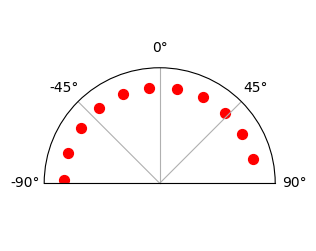

In [28]:
K = 11
rng = np.random.RandomState(42)

pi_segment = np.pi
step = pi_segment / K
start = rng.uniform(-np.pi/2, np.pi/2)

# Генерация точек с «обёртыванием»
theta = np.array([(start + i*step + np.pi/2) % pi_segment - np.pi/2 for i in range(K)])

# Визуализация
fig, ax = plt.subplots(figsize=(6,3), subplot_kw={'projection': 'polar'})

# Полукруг: theta от -pi/2 до pi/2
ax.set_theta_zero_location("N")  # ноль вверх
ax.set_theta_direction(-1)       # по часовой стрелке

# Рисуем точки
ax.scatter(theta, np.ones_like(theta), c='red', s=50)

# Рисуем полуокружность
ax.set_thetamin(-90)
ax.set_thetamax(90)
ax.set_rmax(1.2)
ax.set_rticks([])
ax.set_yticklabels([])
plt.show()